# WADI Anomaly Detection Analysis

This notebook provides a comprehensive anomaly detection analysis on the WADI (Water Distribution) dataset using various machine learning models, including Isolation Forest, Autoencoder, and a hybrid LSTM+CNN model. Finally, it combines their predictions using an ensemble approach to improve overall detection performance.

## Table of Contents
1. [Setup and Imports](#Setup-and-Imports)
2. [GPU Configuration](#GPU-Configuration)
3. [WADIAnomalyDetector Class](#WADIAnomalyDetector-Class)
4. [Usage Example](#Usage-Example)
   - [Loading Data](#Loading-Data)
   - [Running the Analysis](#Running-the-Analysis)
   - [Accessing Results](#Accessing-Results)

---
## Setup and Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

---
## GPU Configuration

In [29]:
# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("Using CPU")

GPU Available:  []
Using CPU


---
## WADIAnomalyDetector Class

This class encapsulates the entire anomaly detection workflow, from data preprocessing to model training, evaluation, and visualization. It supports Isolation Forest, Autoencoder, LSTM+CNN, and an ensemble approach.

In [30]:
class WADIAnomalyDetector:
    def __init__(self, data_path=None, df=None):
        """
        Initialize the WADI Anomaly Detector
        
        Args:
            data_path: Path to CSV file
            df: DataFrame if already loaded
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")
        
        self.models = {}
        self.scalers = {}
        self.results = {}
        self.predictions = {}
        
    def preprocess_data(self, test_size=0.3):
        """Preprocess the WADI dataset"""
        print("Preprocessing data...")
        
        self.df.columns = self.df.columns.str.strip()

        # remove timestamp columns
        #self.df = self.df.drop(columns=['Timestamp', 'Date', 'Time', 'Row'])

        # Convert timestamp columns
        if 'Timestamp' in self.df.columns:
            self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])
        if 'Date' in self.df.columns and 'Time' in self.df.columns:
            self.df['DateTime'] = pd.to_datetime(self.df['Date'] + ' ' + self.df['Time'])
        
        # Extract target variable
        target_col = 'Attack LABLE (1:No Attack, -1:Attack)'
        if target_col in self.df.columns:
            # Convert to binary (0: Normal, 1: Attack)
            self.y = (self.df[target_col] == -1).astype(int)
        else:
            raise ValueError(f"Target column '{target_col}' not found")
        
        # Select feature columns (exclude non-numeric and target columns)
        exclude_cols = ['Timestamp', 'Day', 'Row', 'Date', 'Time', 'DateTime', 
                        target_col, 'PLANT_START_STOP_LOG']
        
        feature_cols = [col for col in self.df.columns if col not in exclude_cols]
        self.X = self.df[feature_cols].copy()
        
        # Handle missing values
        self.X = self.X.fillna(self.X.median())
        
        # Convert boolean/status columns to numeric
        for col in self.X.columns:
            if self.X[col].dtype == 'object':
                self.X[col] = pd.to_numeric(self.X[col], errors='coerce')
        
        self.X = self.X.fillna(0)
        
        print(f"Dataset shape: {self.X.shape}")
        print(f"Attack ratio: {self.y.mean():.4f}")
        
        # Split data
        split_idx = int(len(self.X) * (1 - test_size))
        self.X_train, self.X_test = self.X[:split_idx], self.X[split_idx:]
        self.y_train, self.y_test = self.y[:split_idx], self.y[split_idx:]
        
        # Standardize features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # MinMax scaling for neural networks
        self.minmax_scaler = MinMaxScaler()
        self.X_train_minmax = self.minmax_scaler.fit_transform(self.X_train)
        self.X_test_minmax = self.minmax_scaler.transform(self.X_test)
        
        return self.X_train_scaled, self.X_test_scaled, self.y_train, self.y_test
    
    def train_isolation_forest(self):
        """Train Isolation Forest with hyperparameter tuning"""
        print("\n=== Training Isolation Forest ===")
        
        # Hyperparameter tuning (manual grid search)
        param_grid = {
            'contamination': [0.1, 0.15, 0.2, 0.25],
            'n_estimators': [100, 200, 300],
            'max_samples': ['auto', 0.8, 0.9]
        }
        
        best_score = -np.inf
        best_params = None
        
        for contamination in param_grid['contamination']:
            for n_estimators in param_grid['n_estimators']:
                for max_samples in param_grid['max_samples']:
                    iso_forest = IsolationForest(
                        contamination=contamination,
                        n_estimators=n_estimators,
                        max_samples=max_samples,
                        random_state=42,
                        n_jobs=-1
                    )
                    
                    iso_forest.fit(self.X_train_scaled)
                    scores = iso_forest.decision_function(self.X_train_scaled)
                    
                    # Use negative scores for anomaly detection (higher score = more anomalous)
                    if np.mean(scores) > best_score:
                        best_score = np.mean(scores)
                        best_params = {
                            'contamination': contamination,
                            'n_estimators': n_estimators,
                            'max_samples': max_samples
                        }
        
        print(f"Best Isolation Forest params: {best_params}")
        
        # Train final model with best parameters
        self.models['isolation_forest'] = IsolationForest(**best_params, random_state=42, n_jobs=-1)
        self.models['isolation_forest'].fit(self.X_train_scaled)
        
        # Predictions
        train_pred = self.models['isolation_forest'].predict(self.X_train_scaled)
        test_pred = self.models['isolation_forest'].predict(self.X_test_scaled)
        
        # Convert to binary (1: anomaly, 0: normal)
        self.predictions['isolation_forest'] = {
            'train': (train_pred == -1).astype(int),
            'test': (test_pred == -1).astype(int),
            'train_scores': -self.models['isolation_forest'].decision_function(self.X_train_scaled),
            'test_scores': -self.models['isolation_forest'].decision_function(self.X_test_scaled)
        }
        
        print("Isolation Forest training completed!")
    
    def train_autoencoder(self):
        """Train Autoencoder with hyperparameter tuning"""
        print("\n=== Training Autoencoder ===")
        
        input_dim = self.X_train_minmax.shape[1]
        
        # Hyperparameter options
        architectures = [
            [64, 32, 16, 8, 16, 32, 64],
            [128, 64, 32, 64, 128],
            [256, 128, 64, 32, 64, 128, 256]
        ]
        
        learning_rates = [0.001, 0.0001]
        batch_sizes = [32, 64, 128]
        
        best_loss = np.inf
        best_config = None
        
        for arch in architectures:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Build autoencoder
                    encoder_input = Input(shape=(input_dim,))
                    x = encoder_input
                    
                    # Encoder
                    for units in arch[:len(arch)//2]:
                        x = Dense(units, activation='relu')(x)
                        x = Dropout(0.2)(x)
                    
                    encoded = x
                    
                    # Decoder
                    for units in arch[len(arch)//2:]:
                        x = Dense(units, activation='relu')(x)
                        x = Dropout(0.2)(x)
                    
                    decoded = Dense(input_dim, activation='sigmoid')(x)
                    
                    autoencoder = Model(encoder_input, decoded)
                    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse')
                    
                    # Train with early stopping
                    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
                    
                    # Use only normal data for training
                    normal_indices = self.y_train == 0
                    X_normal = self.X_train_minmax[normal_indices]
                    
                    history = autoencoder.fit(
                        X_normal, X_normal,
                        epochs=10,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stop, reduce_lr],
                        verbose=0
                    )
                    
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_config = {
                            'architecture': arch,
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'model': autoencoder
                        }
        
        print(f"Best Autoencoder config: {best_config['architecture']}, LR: {best_config['learning_rate']}, Batch: {best_config['batch_size']}")
        
        self.models['autoencoder'] = best_config['model']
        
        # Calculate reconstruction errors
        train_pred = self.models['autoencoder'].predict(self.X_train_minmax, verbose=0)
        test_pred = self.models['autoencoder'].predict(self.X_test_minmax, verbose=0)
        
        train_mse = np.mean(np.square(self.X_train_minmax - train_pred), axis=1)
        test_mse = np.mean(np.square(self.X_test_minmax - test_pred), axis=1)
        
        # Determine threshold using training data (e.g., 95th percentile of normal data MSE)
        threshold = np.percentile(train_mse, 95)
        
        self.predictions['autoencoder'] = {
            'train': (train_mse > threshold).astype(int),
            'test': (test_mse > threshold).astype(int),
            'train_scores': train_mse,
            'test_scores': test_mse,
            'threshold': threshold
        }
        
        print("Autoencoder training completed!")
    
    def create_sequences(self, X, seq_length=10):
        """Create sequences for LSTM+CNN"""
        sequences = []
        for i in range(len(X) - seq_length + 1):
            sequences.append(X[i:i+seq_length])
        return np.array(sequences)
    
    def train_lstm_cnn(self):
        """Train LSTM+CNN hybrid model"""
        print("\n=== Training LSTM+CNN Hybrid ===")
        
        seq_length = 10
        
        # Create sequences
        X_train_seq = self.create_sequences(self.X_train_minmax, seq_length)
        X_test_seq = self.create_sequences(self.X_test_minmax, seq_length)
        y_train_seq = self.y_train[seq_length-1:]
        y_test_seq = self.y_test[seq_length-1:]
        
        # Hyperparameter tuning
        configurations = [
            {'cnn_filters': 64, 'lstm_units': 50, 'dense_units': 32, 'lr': 0.001},
            {'cnn_filters': 32, 'lstm_units': 100, 'dense_units': 64, 'lr': 0.0001},
            {'cnn_filters': 128, 'lstm_units': 75, 'dense_units': 50, 'lr': 0.001}
        ]
        
        best_val_loss = np.inf
        best_model = None
        
        for config in configurations:
            # Build LSTM+CNN model
            model = Sequential([
                Conv1D(filters=config['cnn_filters'], kernel_size=3, activation='relu', 
                         input_shape=(seq_length, self.X_train_minmax.shape[1])),
                MaxPooling1D(pool_size=2),
                LSTM(config['lstm_units'], return_sequences=False, dropout=0.3),
                Dense(config['dense_units'], activation='relu'),
                Dropout(0.5),
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=config['lr']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Train model
            early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
            
            history = model.fit(
                X_train_seq, y_train_seq,
                epochs=5,
                batch_size=64,
                validation_split=0.2,
                callbacks=[early_stop, reduce_lr],
                verbose=0
            )
            
            val_loss = min(history.history['val_loss'])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = config
        
        print(f"Best LSTM+CNN config: {best_config}")
        
        self.models['lstm_cnn'] = best_model
        
        # Predictions
        train_prob = self.models['lstm_cnn'].predict(X_train_seq, verbose=0).flatten()
        test_prob = self.models['lstm_cnn'].predict(X_test_seq, verbose=0).flatten()
        
        self.predictions['lstm_cnn'] = {
            'train': (train_prob > 0.5).astype(int),
            'test': (test_prob > 0.5).astype(int),
            'train_scores': train_prob,
            'test_scores': test_prob,
            'y_train_seq': y_train_seq,
            'y_test_seq': y_test_seq
        }
        
        print("LSTM+CNN training completed!")
    
    def train_ensemble_model(self):
        """Train ensemble model combining all three models"""
        print("\n=== Training Ensemble Model ===")
        
        # Get predictions from all models
        iso_scores = self.predictions['isolation_forest']['test_scores']
        ae_scores = self.predictions['autoencoder']['test_scores']
        lstm_scores = self.predictions['lstm_cnn']['test_scores']
        
        # Normalize scores to [0, 1]
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        
        iso_norm = scaler.fit_transform(iso_scores.reshape(-1, 1)).flatten()
        ae_norm = scaler.fit_transform(ae_scores.reshape(-1, 1)).flatten()
        
        # Adjust for LSTM+CNN sequence length differences
        min_len = min(len(iso_norm), len(ae_norm), len(lstm_scores))
        iso_norm = iso_norm[-min_len:]
        ae_norm = ae_norm[-min_len:]
        lstm_norm = lstm_scores[-min_len:]
        
        # Ensemble methods
        ensemble_methods = {
            'average': (iso_norm + ae_norm + lstm_norm) / 3,
            'weighted': 0.3 * iso_norm + 0.3 * ae_norm + 0.4 * lstm_norm, # Example weights, can be tuned
            'max': np.maximum(np.maximum(iso_norm, ae_norm), lstm_norm)
        }
        
        best_method = None
        best_auc = 0
        
        y_test_adj = self.y_test[-min_len:]
        
        for method_name, scores in ensemble_methods.items():
            try:
                auc = roc_auc_score(y_test_adj, scores)
                if auc > best_auc:
                    best_auc = auc
                    best_method = method_name
            except:
                # Handle cases where ROC AUC cannot be computed (e.g., all 0s or 1s)
                continue
        
        print(f"Best ensemble method: {best_method} (AUC: {best_auc:.4f})")
        
        self.predictions['ensemble'] = {
            'test': (ensemble_methods[best_method] > 0.5).astype(int), # Threshold of 0.5 for binary prediction
            'test_scores': ensemble_methods[best_method],
            'y_test_adj': y_test_adj,
            'method': best_method
        }
        
        print("Ensemble training completed!")
    
    def evaluate_models(self):
        """Evaluate all models and generate results"""
        print("\n=== Model Evaluation ===")
        
        self.results = {}
        
        # Isolation Forest
        try:
            auc_if = roc_auc_score(self.y_test, self.predictions['isolation_forest']['test_scores'])
            precision_if = average_precision_score(self.y_test, self.predictions['isolation_forest']['test_scores'])
            
            self.results['Isolation Forest'] = {
                'AUC': auc_if,
                'Average Precision': precision_if,
                'Classification Report': classification_report(
                    self.y_test, self.predictions['isolation_forest']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating Isolation Forest: {e}")
        
        # Autoencoder
        try:
            auc_ae = roc_auc_score(self.y_test, self.predictions['autoencoder']['test_scores'])
            precision_ae = average_precision_score(self.y_test, self.predictions['autoencoder']['test_scores'])
            
            self.results['Autoencoder'] = {
                'AUC': auc_ae,
                'Average Precision': precision_ae,
                'Classification Report': classification_report(
                    self.y_test, self.predictions['autoencoder']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating Autoencoder: {e}")
        
        # LSTM+CNN
        try:
            y_test_seq = self.predictions['lstm_cnn']['y_test_seq']
            auc_lstm = roc_auc_score(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            precision_lstm = average_precision_score(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            
            self.results['LSTM+CNN'] = {
                'AUC': auc_lstm,
                'Average Precision': precision_lstm,
                'Classification Report': classification_report(
                    y_test_seq, self.predictions['lstm_cnn']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating LSTM+CNN: {e}")
        
        # Ensemble
        try:
            y_test_adj = self.predictions['ensemble']['y_test_adj']
            auc_ensemble = roc_auc_score(y_test_adj, self.predictions['ensemble']['test_scores'])
            precision_ensemble = average_precision_score(y_test_adj, self.predictions['ensemble']['test_scores'])
            
            self.results['Ensemble'] = {
                'AUC': auc_ensemble,
                'Average Precision': precision_ensemble,
                'Classification Report': classification_report(
                    y_test_adj, self.predictions['ensemble']['test'], output_dict=True
                )
            }
        except Exception as e:
            print(f"Error evaluating Ensemble: {e}")
        
        # Print results
        print("\n" + "="*60)
        print("MODEL PERFORMANCE COMPARISON")
        print("="*60)
        
        for model_name, metrics in self.results.items():
            print(f"\n{model_name}:")
            print(f"  AUC-ROC: {metrics['AUC']:.4f}")
            print(f"  Average Precision: {metrics['Average Precision']:.4f}")
            if 'macro avg' in metrics['Classification Report']:
                print(f"  F1-Score: {metrics['Classification Report']['macro avg']['f1-score']:.4f}")
                print(f"  Precision: {metrics['Classification Report']['macro avg']['precision']:.4f}")
                print(f"  Recall: {metrics['Classification Report']['macro avg']['recall']:.4f}")
    
    def plot_results(self):
        """Create comprehensive visualizations"""
        print("\n=== Generating Visualizations ===")
        
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 15))
        
        # 1. ROC Curves
        plt.subplot(2, 3, 1)
        
        # Isolation Forest ROC
        try:
            fpr_if, tpr_if, _ = roc_curve(self.y_test, self.predictions['isolation_forest']['test_scores'])
            plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {self.results["Isolation Forest"]["AUC"]:.3f})')
        except:
            pass
        
        # Autoencoder ROC
        try:
            fpr_ae, tpr_ae, _ = roc_curve(self.y_test, self.predictions['autoencoder']['test_scores'])
            plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {self.results["Autoencoder"]["AUC"]:.3f})')
        except:
            pass
        
        # LSTM+CNN ROC
        try:
            y_test_seq = self.predictions['lstm_cnn']['y_test_seq']
            fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM+CNN (AUC = {self.results["LSTM+CNN"]["AUC"]:.3f})')
        except:
            pass
        
        # Ensemble ROC
        try:
            y_test_adj = self.predictions['ensemble']['y_test_adj']
            fpr_ens, tpr_ens, _ = roc_curve(y_test_adj, self.predictions['ensemble']['test_scores'])
            plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {self.results["Ensemble"]["AUC"]:.3f})', linewidth=2)
        except:
            pass
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Precision-Recall Curves
        plt.subplot(2, 3, 2)
        
        try:
            precision_if, recall_if, _ = precision_recall_curve(self.y_test, self.predictions['isolation_forest']['test_scores'])
            plt.plot(recall_if, precision_if, label=f'Isolation Forest (AP = {self.results["Isolation Forest"]["Average Precision"]:.3f})')
        except:
            pass
        
        try:
            precision_ae, recall_ae, _ = precision_recall_curve(self.y_test, self.predictions['autoencoder']['test_scores'])
            plt.plot(recall_ae, precision_ae, label=f'Autoencoder (AP = {self.results["Autoencoder"]["Average Precision"]:.3f})')
        except:
            pass
        
        try:
            precision_lstm, recall_lstm, _ = precision_recall_curve(y_test_seq, self.predictions['lstm_cnn']['test_scores'])
            plt.plot(recall_lstm, precision_lstm, label=f'LSTM+CNN (AP = {self.results["LSTM+CNN"]["Average Precision"]:.3f})')
        except:
            pass
        
        try:
            precision_ens, recall_ens, _ = precision_recall_curve(y_test_adj, self.predictions['ensemble']['test_scores'])
            plt.plot(recall_ens, precision_ens, label=f'Ensemble (AP = {self.results["Ensemble"]["Average Precision"]:.3f})', linewidth=2)
        except:
            pass
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Performance Comparison Bar Chart
        plt.subplot(2, 3, 3)
        models = list(self.results.keys())
        auc_scores = [self.results[model]['AUC'] for model in models]
        ap_scores = [self.results[model]['Average Precision'] for model in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        plt.bar(x - width/2, auc_scores, width, label='AUC-ROC', alpha=0.8)
        plt.bar(x + width/2, ap_scores, width, label='Average Precision', alpha=0.8)
        
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Performance Comparison')
        plt.xticks(x, models, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Confusion Matrices (first two models)
        for i, model_name in enumerate(['Isolation Forest', 'Autoencoder']):
            plt.subplot(2, 3, 4 + i)
            if model_name in self.results:
                if model_name == 'Isolation Forest':
                    cm = confusion_matrix(self.y_test, self.predictions['isolation_forest']['test'])
                else:
                    cm = confusion_matrix(self.y_test, self.predictions['autoencoder']['test'])
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'{model_name} Confusion Matrix')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
        
        # 6. Anomaly Score Distributions (Example: Isolation Forest)
        plt.subplot(2, 3, 6)
        
        try:
            # Plot score distributions for each model
            plt.hist(self.predictions['isolation_forest']['test_scores'][self.y_test == 0], 
                     alpha=0.5, bins=50, label='IF Normal', density=True)
            plt.hist(self.predictions['isolation_forest']['test_scores'][self.y_test == 1], 
                     alpha=0.5, bins=50, label='IF Attack', density=True)
            
            plt.xlabel('Anomaly Score')
            plt.ylabel('Density')
            plt.title('Isolation Forest Score Distributions')
            plt.legend()
            plt.grid(True, alpha=0.3)
        except:
            pass # Handle cases where data might be missing or cause errors
        
        plt.tight_layout()
        plt.show()
        
        # Additional detailed results table
        self.create_results_table()
    
    def create_results_table(self):
        """Create a detailed results table"""
        print("\n" + "="*80)
        print("DETAILED RESULTS TABLE")
        print("="*80)
        
        results_df = []
        for model_name, metrics in self.results.items():
            row = {
                'Model': model_name,
                'AUC-ROC': f"{metrics['AUC']:.4f}",
                'Average Precision': f"{metrics['Average Precision']:.4f}"
            }
            
            if 'macro avg' in metrics['Classification Report']:
                row['Precision'] = f"{metrics['Classification Report']['macro avg']['precision']:.4f}"
                row['Recall'] = f"{metrics['Classification Report']['macro avg']['recall']:.4f}"
                row['F1-Score'] = f"{metrics['Classification Report']['macro avg']['f1-score']:.4f}"
            
            results_df.append(row)
        
        results_df = pd.DataFrame(results_df)
        print(results_df.to_string(index=False))
        
        return results_df
    
    def run_complete_analysis(self):
        """Run the complete anomaly detection analysis"""
        print("Starting WADI Anomaly Detection Analysis")
        print("="*50)
        
        # Preprocess data
        self.preprocess_data()
        
        # Train all models
        self.train_isolation_forest()
        self.train_autoencoder()
        self.train_lstm_cnn()
        self.train_ensemble_model()
        
        # Evaluate models
        self.evaluate_models()
        
        # Generate visualizations
        self.plot_results()
        
        print("\n" + "="*50)
        print("Analysis Complete!")
        print("="*50)
        
        return self.results, self.predictions

---
## Usage Example

Here's how you can use the `WADIAnomalyDetector` class to load your data and run the complete anomaly detection analysis. **Remember to replace `'path_to_your_wadi_dataset.csv'` with the actual path to your WADI dataset.**

### Loading Data

You can load your WADI dataset either from a CSV file or by passing an existing Pandas DataFrame.

In [31]:
# For demonstration purposes, let's create a dummy DataFrame if you don't have a WADI dataset readily available.
# In a real scenario, you would load your actual WADI dataset.

# ---
## Data Loading Example

try:
    file_path = 'WADI_attackdataLABLE.csv'
    print(f"Attempting to load data from: {file_path}")
    detector = WADIAnomalyDetector(data_path=file_path)
    print("WADIAnomalyDetector instance created successfully from CSV.")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the CSV file is in the correct directory or provide its full path.")
    print("Falling back to dummy data creation for demonstration purposes.")

    # --- Option 2: Create a dummy DataFrame if the file is not found ---
    # This block will only execute if FileNotFoundError occurs.
    print("Creating a dummy DataFrame for demonstration.")
    np.random.seed(42)
    n_samples = 100000
    n_features = 127 # Example number of features
    dummy_data = np.random.rand(n_samples, n_features)
    dummy_cols = [f'FEATURE_{i}' for i in range(n_features)]
    dummy_df = pd.DataFrame(dummy_data, columns=dummy_cols)

    # Add 'Attack LABLE (1:No Attack, -1:Attack)' column for the dummy data
    dummy_df['Attack LABLE (1:No Attack, -1:Attack)'] = np.random.choice([1, -1], size=n_samples, p=[0.9, 0.1])
    
    # Add 'Timestamp' column for the dummy data
    dummy_df['Timestamp'] = pd.to_datetime(pd.date_range(start='2023-01-01', periods=n_samples, freq='min'))
    
    detector = WADIAnomalyDetector(df=dummy_df)
    print("Dummy WADIAnomalyDetector instance created.")

except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")

Attempting to load data from: WADI_attackdataLABLE.csv
WADIAnomalyDetector instance created successfully from CSV.


### Running the Analysis

Once the detector is initialized, you can run the complete analysis, which includes preprocessing, training all models, evaluating them, and generating plots.

Starting WADI Anomaly Detection Analysis
Preprocessing data...
Dataset shape: (172803, 126)
Attack ratio: 0.0577

=== Training Isolation Forest ===
Best Isolation Forest params: {'contamination': 0.1, 'n_estimators': 100, 'max_samples': 'auto'}
Isolation Forest training completed!

=== Training Autoencoder ===
Best Autoencoder config: [128, 64, 32, 64, 128], LR: 0.001, Batch: 128
Autoencoder training completed!

=== Training LSTM+CNN Hybrid ===
Best LSTM+CNN config: {'cnn_filters': 128, 'lstm_units': 75, 'dense_units': 50, 'lr': 0.001}
LSTM+CNN training completed!

=== Training Ensemble Model ===
Best ensemble method: weighted (AUC: 0.9122)
Ensemble training completed!

=== Model Evaluation ===

MODEL PERFORMANCE COMPARISON

Isolation Forest:
  AUC-ROC: 0.8886
  Average Precision: 0.2636
  F1-Score: 0.6202
  Precision: 0.6018
  Recall: 0.7987

Autoencoder:
  AUC-ROC: 0.8752
  Average Precision: 0.4599
  F1-Score: 0.4487
  Precision: 0.5541
  Recall: 0.7376

LSTM+CNN:
  AUC-ROC: 0.6854


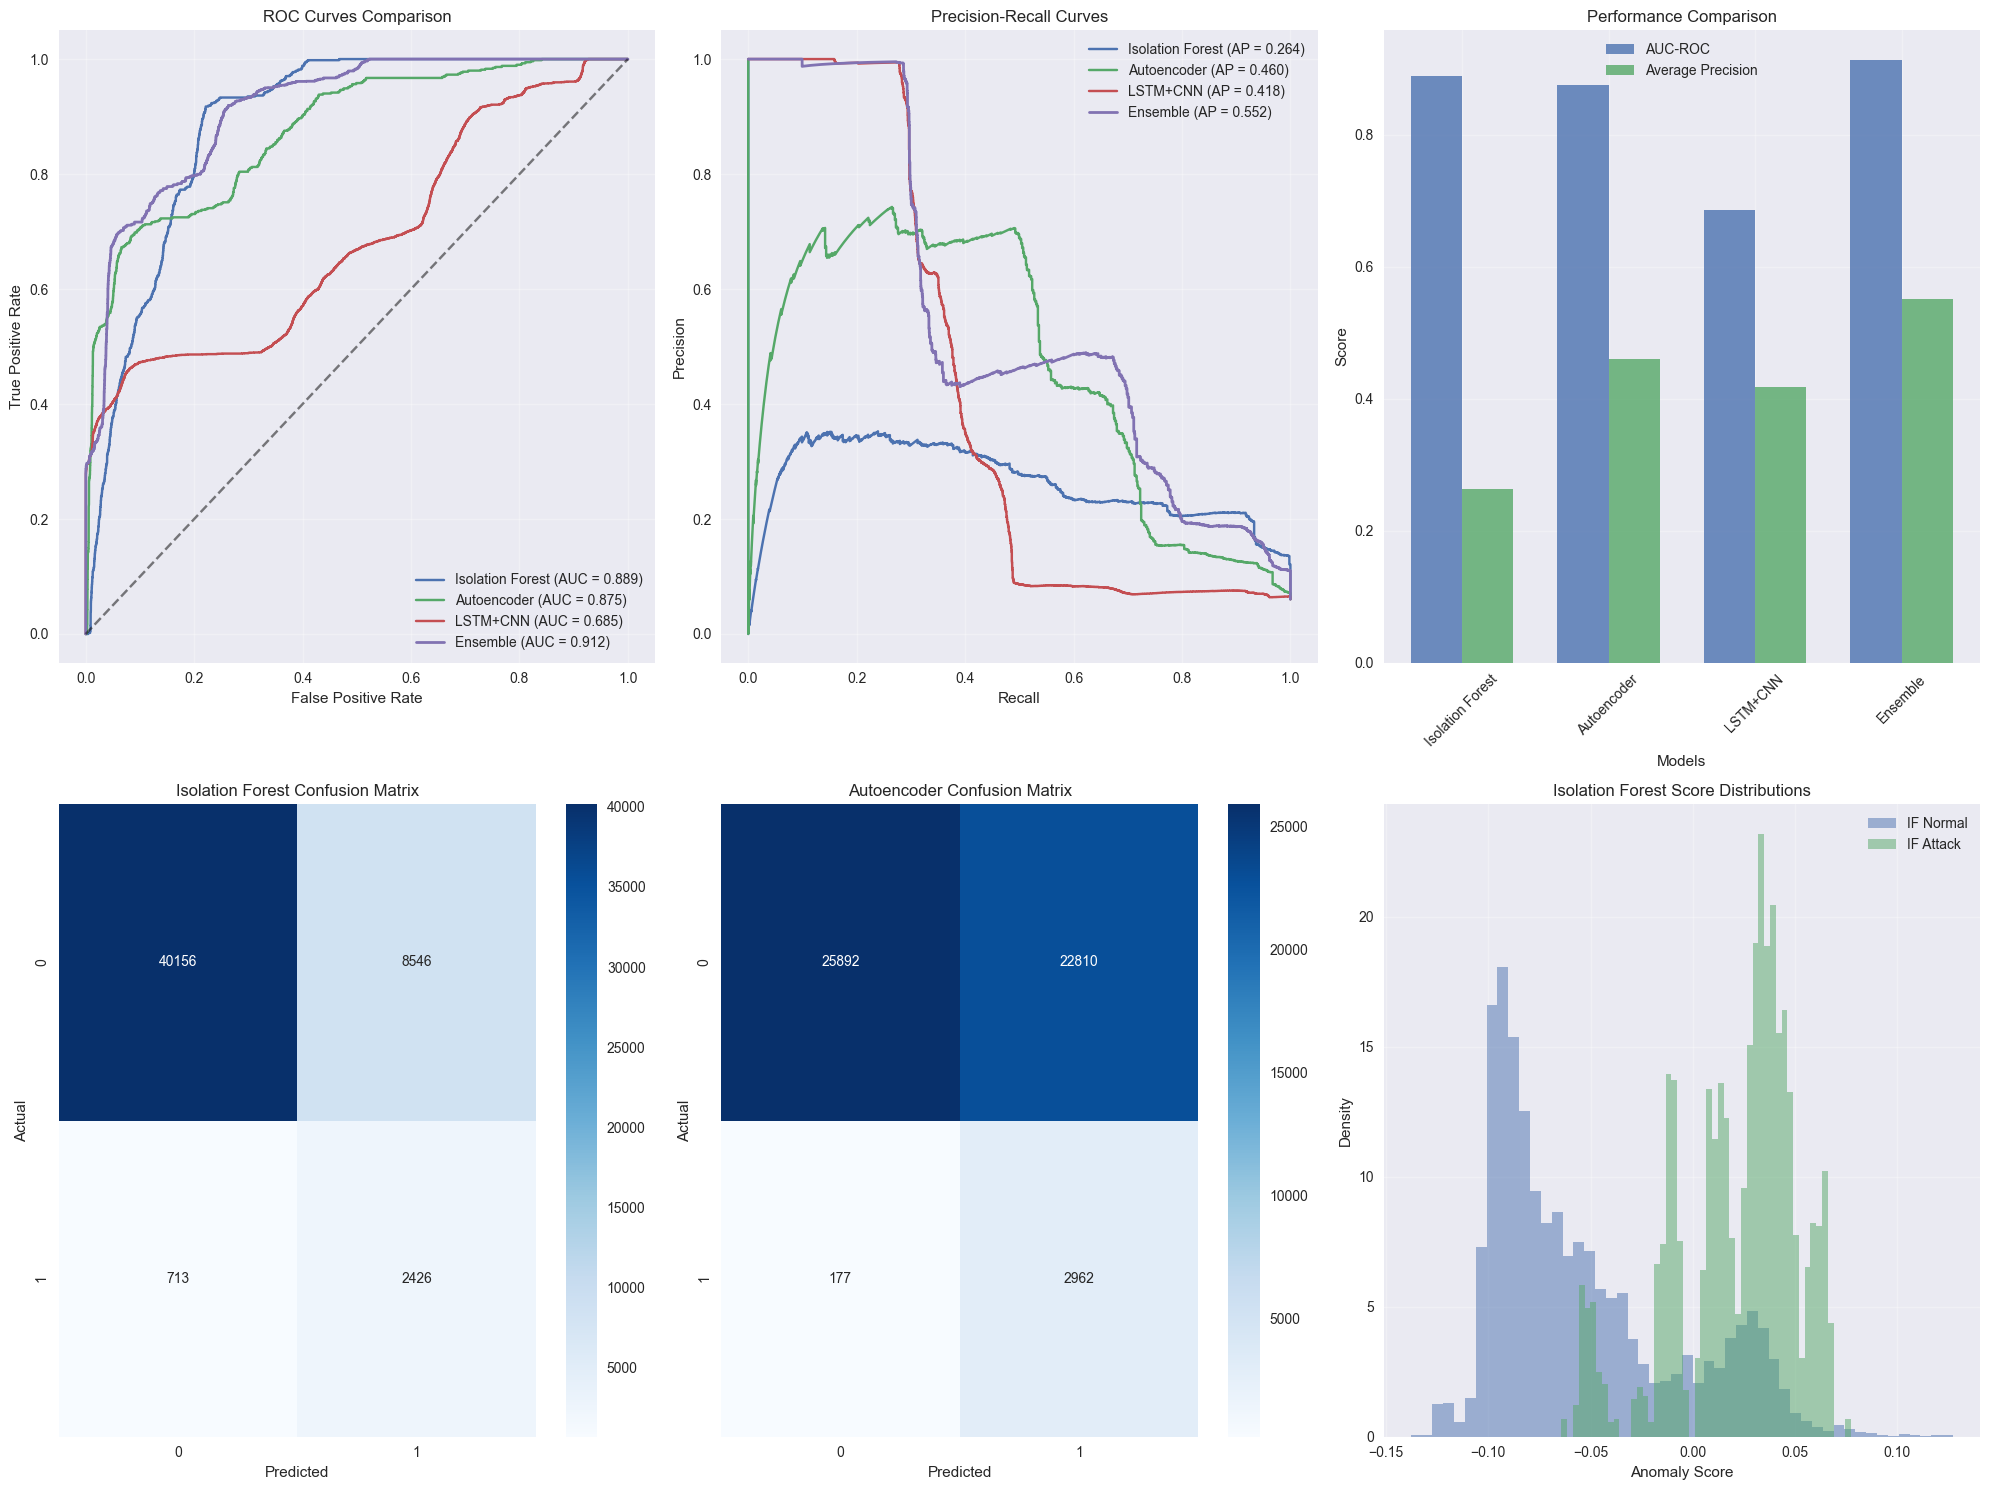


DETAILED RESULTS TABLE
           Model AUC-ROC Average Precision Precision Recall F1-Score
Isolation Forest  0.8886            0.2636    0.6018 0.7987   0.6202
     Autoencoder  0.8752            0.4599    0.5541 0.7376   0.4487
        LSTM+CNN  0.6854            0.4178    0.9320 0.6461   0.7105
        Ensemble  0.9122            0.5516    0.9306 0.6471   0.7116

Analysis Complete!


In [32]:
# Ensure 'detector' object is initialized before running this cell
if 'detector' in locals():
    results, predictions = detector.run_complete_analysis()
else:
    print("Detector object not initialized. Please run the data loading cell first.")

### Accessing Results

You can access the performance metrics and predictions of each model after the `run_complete_analysis` method completes.

In [33]:
if 'results' in locals() and 'predictions' in locals():
    print("\n--- Sample Results ---")
    if 'Isolation Forest' in results:
        print(f"Isolation Forest AUC: {results['Isolation Forest']['AUC']:.4f}")
    if 'Ensemble' in results:
        print(f"Ensemble AUC: {results['Ensemble']['AUC']:.4f}")
    if 'Autoencoder' in results:
        print(f"Autoencoder AUC: {results['Autoencoder']['AUC']:.4f}")
    
    print("\n--- Sample Predictions (Ensemble) ---")
    if 'ensemble' in predictions:
        print(predictions['ensemble']['test'][:10])
else:
    print("Results and predictions not available. Please run the analysis first.")
#save_dir = detector.save_models_and_results()



--- Sample Results ---
Isolation Forest AUC: 0.8886
Ensemble AUC: 0.9122
Autoencoder AUC: 0.8752

--- Sample Predictions (Ensemble) ---
[0 0 0 0 0 0 0 0 0 0]
